In [1]:
%load_ext autoreload
%autoreload 2

import os
import glob

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from matplotlib.ticker import AutoMinorLocator

import utils

%matplotlib inline

plt.style.use('/mnt/home/tnguyen/default.mplstyle')

### Read data

In [22]:
data_root = "/mnt/ceph/users/tnguyen/florah/sc-sam/florah-tree/"
sim_table = utils.read_all_props(os.path.join(data_root, 'vsmdpl_sim/output'))
gen_table = utils.read_all_props(os.path.join(data_root, 'vsmdpl_gen/output'))
z = 0
sat_types = [0, 1, 2, 3]

select = (sim_table['mstar'] > 0) & np.isin(sim_table['sat_type'], sat_types)
sim_table = sim_table[select]
select = (gen_table['mstar'] > 0) & np.isin(gen_table['sat_type'], sat_types)
gen_table = gen_table[select]

In [3]:
mhalo_bins = np.arange(5.5, 12.5, 0.25)
mhalo_bins_ce = 0.5 * (mhalo_bins[1:] + mhalo_bins[:-1])
num_bins = len(mhalo_bins) - 1
q = [50, 16, 84]
min_count = 10

### Stellar mass

In [4]:
sim_log_mstar = np.log10(sim_table['mstar'].to_numpy()) + 9
sim_log_mhalo = np.log10(sim_table['mhalo'].to_numpy()) + 9
gen_log_mstar = np.log10(gen_table['mstar'].to_numpy()) + 9
gen_log_mhalo = np.log10(gen_table['mhalo'].to_numpy()) + 9

sim_log_mstar_q = np.zeros((num_bins, len(q)))
gen_log_mstar_q = np.zeros((num_bins, len(q)))
for i in range(num_bins):
    select = (sim_log_mhalo > mhalo_bins[i]) & (sim_log_mhalo < mhalo_bins[i+1])
    if select.sum() < min_count:
        sim_log_mstar_q[i] = np.nan
    else:
        sim_log_mstar_q[i] = np.nanpercentile(sim_log_mstar[select], q)

    select = (gen_log_mhalo > mhalo_bins[i]) & (gen_log_mhalo < mhalo_bins[i+1])
    if select.sum() < min_count:
        gen_log_mstar_q[i] = np.nan
    else:
        gen_log_mstar_q[i] = np.nanpercentile(gen_log_mstar[select], q)

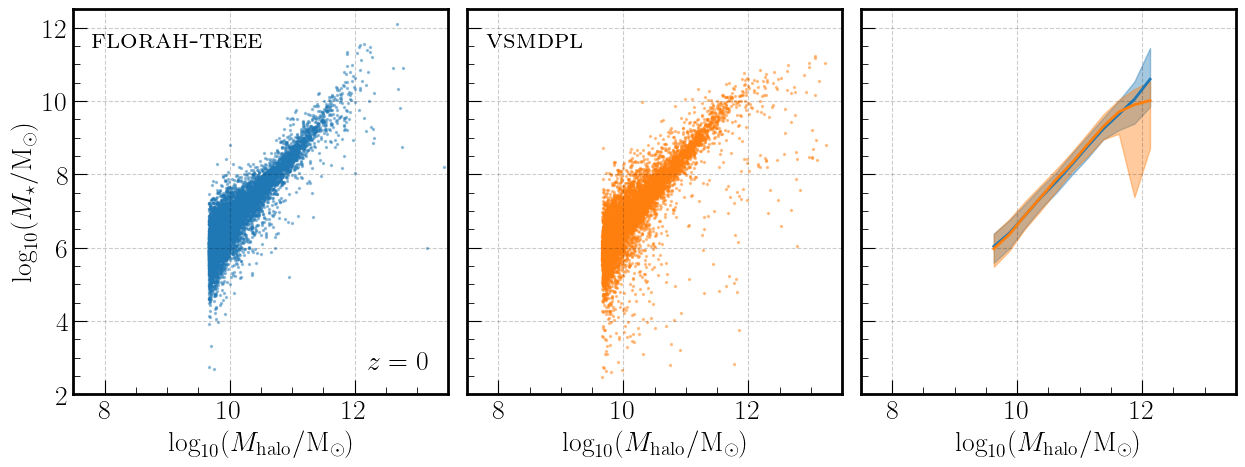

In [21]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)

sim_label = r'\textsc{vsmdpl}'
gen_label = r'\textsc{florah-tree}'
gen_color = 'C0'
sim_color = 'C1'
xlim = (min(mhalo_bins), max(mhalo_bins))
xlim = (7.5, 13.5)
ylim = (2, 12.5)

# plot only the generated galaxies
axes[0].scatter(
    gen_log_mhalo, gen_log_mstar, s=2, alpha=0.4, c='C0')

# plot only the simulated galaxies
axes[1].scatter(
    sim_log_mhalo, sim_log_mstar, s=2, alpha=0.4, c='C1')

# plot both but only the median and 16-84 percentile
axes[2].plot(
    mhalo_bins_ce, gen_log_mstar_q[:, 0], color=gen_color, lw=2)
axes[2].fill_between(
    mhalo_bins_ce, gen_log_mstar_q[:, 1], gen_log_mstar_q[:, 2],
    alpha=0.4, color=gen_color)
axes[2].plot(
    mhalo_bins_ce, sim_log_mstar_q[:, 0], color=sim_color, lw=2)
axes[2].fill_between(
    mhalo_bins_ce, sim_log_mstar_q[:, 1], sim_log_mstar_q[:, 2],
    alpha=0.4, color=sim_color)

axes[0].set_ylabel(r'$\log_{10}(M_{\star}/ \rm M_{\odot})$')
for ax in axes:
    ax.set_xlabel(r'$\log_{10}(M_{\rm halo}/ \rm M_{\odot})$')
axes[0].set_xlim(xlim)
axes[0].set_ylim(ylim)

# annotate the panels
axes[0].text(
    0.05, 0.95, gen_label,
    transform=axes[0].transAxes, ha='left', va='top')
axes[1].text(
    0.05, 0.95, sim_label,
    transform=axes[1].transAxes, ha='left', va='top')

# redshift at the lower right
axes[0].text(
    0.95, 0.05, r'$z={{{}}}$'.format(z),
    transform=axes[0].transAxes, ha='right', va='bottom')

fig.subplots_adjust(wspace=0.05)
plt.show()

### SHMR residual vs DM concentration

In [19]:
sim_log_mstar = np.log10(sim_table['mstar'].to_numpy()) + 9
sim_log_mhalo = np.log10(sim_table['mhalo'].to_numpy()) + 9
gen_log_mstar = np.log10(gen_table['mstar'].to_numpy()) + 9
gen_log_mhalo = np.log10(gen_table['mhalo'].to_numpy()) + 9
sim_log_ratio = sim_log_mstar - sim_log_mhalo
gen_log_ratio = gen_log_mstar - gen_log_mhalo
sim_log_cvir = np.log10(sim_table['c_nfw'].to_numpy())
gen_log_cvir = np.log10(gen_table['c_nfw'].to_numpy())

q = [50, 16, 84]
bins = np.linspace(0, 3, 10)  # this is concentration bin, not mass bin
bin_centers = (bins[:-1] + bins[1:]) / 2
nbins = len(bin_centers)
min_num_bin = 10
nbins_mass = 20

# calculate the median ratio in each mass bins
median = stats.binned_statistic(sim_log_mhalo, sim_log_ratio, 'median', bins=nbins_mass)
sim_shmr = sim_log_ratio.copy()
for i in range(len(median.statistic)):
    select = (median.binnumber-1==i)
    if select.sum() == 0:
        continue
    sim_shmr[select] = sim_shmr[select] - median.statistic[i]

median = stats.binned_statistic(gen_log_mhalo, gen_log_ratio, 'median', bins=nbins_mass)
gen_shmr = gen_log_ratio.copy()
for i in range(len(median.statistic)):
    select = (median.binnumber-1==i)
    if select.sum() == 0:
        continue
    gen_shmr[select] = gen_shmr[select] - median.statistic[i]

# bin everything by cvir and calculate the median and 16-84 percentile of the SHMR
sim_shmr_q = np.zeros((nbins, 3))
gen_shmr_q = np.zeros((nbins, 3))
for i in range(nbins):
    select = (sim_log_cvir >= bins[i]) & (sim_log_cvir < bins[i+1])
    if select.sum() < min_num_bin:
        sim_shmr_q[i] = np.nan
    else:
        sim_shmr_q[i] = np.nanpercentile(sim_shmr[select], q)
    select = (gen_log_cvir >= bins[i]) & (gen_log_cvir < bins[i+1])
    if select.sum() < min_num_bin:
        gen_shmr_q[i] = np.nan
    else:
        gen_shmr_q[i] = np.nanpercentile(gen_shmr[select], q)

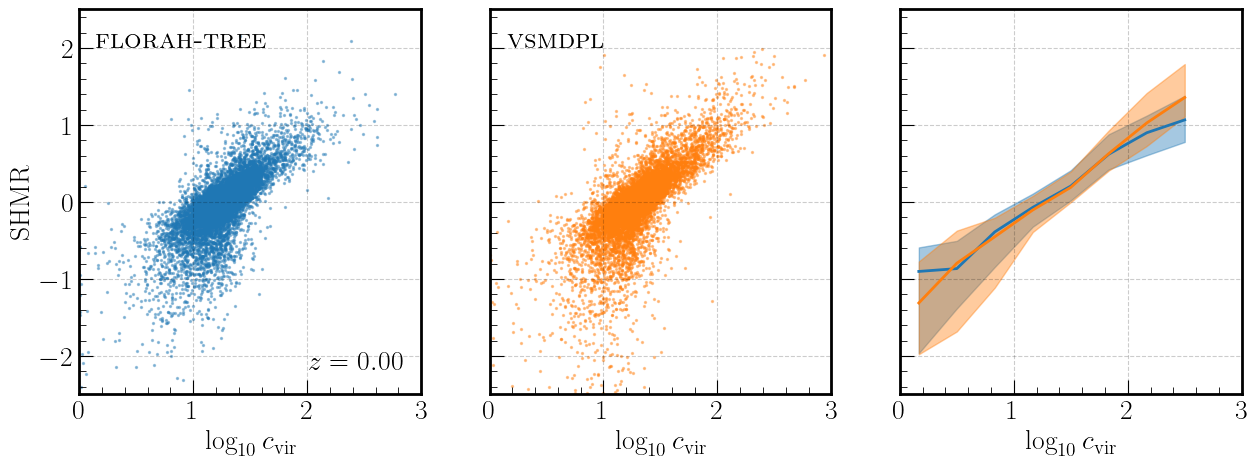

In [20]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)

gen_label = r'\textsc{florah-tree}'
sim_label = r'\textsc{vsmdpl}'
gen_color = 'C0'
sim_color = 'C1'
xlim = (0, 3)
ylim = (-2.5, 2.5)

# plot only the generated galaxies
axes[0].scatter(
    gen_log_cvir, gen_shmr, s=2, alpha=0.4, c='C0')

# plot only the simulated galaxies
axes[1].scatter(
    sim_log_cvir, sim_shmr, s=2, alpha=0.4, c='C1')

# plot both but only the median and 16-84 percentile
axes[2].plot(
    bin_centers, gen_shmr_q[:, 0], color=gen_color, lw=2,
    label=r'\textsc{florah-tree}')
axes[2].fill_between(
    bin_centers, gen_shmr_q[:, 1], gen_shmr_q[:, 2],
    alpha=0.4, color=gen_color)
axes[2].plot(
    bin_centers, sim_shmr_q[:, 0], color=sim_color, lw=2,
    label=r'\textsc{gureft-05}')
axes[2].fill_between(
    bin_centers, sim_shmr_q[:, 1], sim_shmr_q[:, 2],
    alpha=0.4, color=sim_color)

axes[0].set_ylabel(r'SHMR')
axes[0].set_xlabel(r'$\log_{10}c_{\rm vir}$')
axes[1].set_xlabel(r'$\log_{10}c_{\rm vir}$')
axes[2].set_xlabel(r'$\log_{10}c_{\rm vir}$')
axes[0].set_xlim(xlim)
axes[0].set_ylim(ylim)

# annotate the panels
axes[0].text(
    0.05, 0.95, gen_label,
    transform=axes[0].transAxes, ha='left', va='top')
axes[1].text(
    0.05, 0.95, sim_label,
    transform=axes[1].transAxes, ha='left', va='top')

# redshift at the lower right
axes[0].text(
    0.95, 0.05, r'$z={:.2f}$'.format(z),
    transform=axes[0].transAxes, ha='right', va='bottom')

plt.show()